In [211]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import random
import os
import time
import math

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
DEVICE = torch.device('cuda')

In [212]:
a = torch.tensor([2,7,3,8,1,4])
print(a)
sort_a_index = torch.argsort(a)
print(sort_a_index)
random = torch.tensor([1,2,3,4,5,6])
random = torch.sort(random).values
print(random)
tmp = torch.zeros(len(random)).long()
tmp[sort_a_index] = torch.arange(len(random))
random = random[tmp]
print(random)

tensor([2, 7, 3, 8, 1, 4])
tensor([4, 0, 2, 5, 1, 3])
tensor([1, 2, 3, 4, 5, 6])
tensor([2, 5, 3, 6, 1, 4])


In [213]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return TensorDataset(X, Y)

In [214]:
def get_Cifar10_dl(batch_size_train=256, batch_size_eval=1024, device=DEVICE):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = CIFAR10('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [45000,5000])
    
    data_test = CIFAR10('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [215]:
def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [216]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [217]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()

In [218]:
#stats = {'train-loss' : [], 'valid-acc' : [], 'diff_mean' : [], 'diff_variance' : [], 'cosine' : [], 'scale_diff' : []}
def print_stats_full(stats):

  fig, axs= plt.subplots(3, 2, figsize=(7,9), dpi=110)

  axs[0, 0].set_title("ERM loss")
  axs[0, 1].set_title("Valid Acc")
  axs[1, 0].set_title("diff mean")
  axs[1, 1].set_title("diff variance")
  axs[2, 0].set_title("cosine")
  axs[2, 1].set_title("scale_diff")
  #axs[2, 1].set_title("same_sign_perc")


  for i in range(3):
    for j in range(2):
      axs[i, j].set_xlabel("iterations")
      axs[i, j].grid()
  
  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  axs[0, 0].set_ylim(0.0, max(loss))
  axs[0, 0].plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  axs[0, 1].set_ylim(0.0, 1.05)
  axs[0, 1].plot(itrs, acc)

  itrs = [x[0] for x in stats['diff_mean']]
  diff_mean = [x[1].cpu() for x in stats['diff_mean']]
  axs[1, 0].set_ylim(min(diff_mean), max(diff_mean))
  axs[1, 0].plot(itrs, diff_mean)

  itrs = [x[0] for x in stats['diff_mean']]
  diff_variance = [x[1].cpu() for x in stats['diff_mean']]
  axs[1, 1].set_ylim(0.0, max(diff_variance))
  axs[1, 1].plot(itrs, diff_variance)

  itrs = [x[0] for x in stats['cosine']]
  cosine = [x[1].cpu() for x in stats['cosine']]
  axs[2, 0].set_ylim(min(cosine), max(cosine))
  axs[2, 0].plot(itrs, cosine)

  
  itrs = [x[0] for x in stats['scale_diff']]
  scale_diff = [x[1].cpu() for x in stats['scale_diff']]
  axs[2, 1].set_ylim(min(scale_diff), max(scale_diff))
  axs[2, 1].plot(itrs, scale_diff)
  '''
  itrs = [x[0] for x in stats['same_sign_perc']]
  scale_diff = [x[1].cpu() for x in stats['same_sign_perc']]
  axs[2, 1].set_ylim(0, 1)
  axs[2, 1].plot(itrs, scale_diff)
  '''
  plt.tight_layout()
  fig.savefig('testing.jpg', bbox_inches = 'tight')

In [219]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, max(loss))
  ax2.set_ylim(0.0, 1.05)
  fig.savefig('testing.jpg', bbox_inches = 'tight')

In [220]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        '''
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        '''
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(4*4*512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        #out = self.layer9(out)
        '''
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        '''
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [221]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(1024, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc4(out)
        return out

In [222]:
def run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, use_momentum, check_gap, shuffle_ratio, decay_rate):
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : [], 'diff_mean' : [], 'diff_variance' : [], 'cosine' : [], 'scale_diff' : [], 'same_sign_perc' : []}

    if use_forward_grad:
        random_dir = {}
        if use_momentum:
            master_dir = {}
            for i, p in enumerate(model.parameters()):
                random_dir[i] = 0
                master_dir[i] = 0
        else:
            for i, p in enumerate(model.parameters()):
                random_dir[i] = 0
        
    for epoch in range(max_epochs):
        for x, y in train_dl:
            itr += 1
            opt.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()

            if use_forward_grad:
                with torch.no_grad():
                    da = torch.zeros((num_dir, 1), device = DEVICE)
                
                    if use_momentum:
                        if itr % check_gap == 0:
                            for i, p in enumerate(model.parameters()):
                                g = p.grad.view(-1)
                                index_sort = torch.argsort(g)
                                master_dir[i] = index_sort
                    
                    for i, p in enumerate(model.parameters()):
                        g = p.grad.view(-1)
                        v = torch.randn(num_dir, len(g), device = DEVICE)

                        if use_momentum:
                            for j in range(num_dir):
                                v[j] = torch.sort(v[j]).values
                                tmp = torch.zeros(len(v[j])).to(DEVICE).long()
                                tmp_dir = torch.tensor([]).to(DEVICE).long()

                                if shuffle_ratio != 0:
                                    for k in range(int(1/shuffle_ratio)):
                                        if k<(int(1/shuffle_ratio)-1):
                                            partial_master_dir = master_dir[i][int(k*shuffle_ratio*master_dir[i].nelement()) : int((k+1)*shuffle_ratio*master_dir[i].nelement())]
                                        else:
                                            partial_master_dir = master_dir[i][int(k*shuffle_ratio*master_dir[i].nelement()) : ]
                                        partial_shuffle_idx = torch.randperm(partial_master_dir.nelement())
                                        partial_tmp_dir = partial_master_dir[partial_shuffle_idx]
                                        tmp_dir = torch.cat((tmp_dir, partial_tmp_dir))

                                else:
                                    tmp_dir = master_dir[i]
                                
                                tmp[tmp_dir] = torch.arange(len(v[j])).to(DEVICE)
                                v[j] = v[j][tmp]
                            
                            v_random = torch.randn(num_dir, len(g), device = DEVICE)
                            v = v_random*(min(0.9, 1-(decay_rate**(itr%check_gap)))) + v*(max(0.1, decay_rate**(itr%check_gap)))

                        random_dir[i] = v
                        da += (v@g).view(num_dir, 1)

                    estimation = torch.tensor([]).to(DEVICE)
                    true_gradient = torch.tensor([]).to(DEVICE)
                    for i, p in enumerate(model.parameters()):
                        g = da*random_dir[i]
                        true_gradient = torch.cat((true_gradient, p.grad.view(-1)), dim = 0)
                        estimation = torch.cat((estimation, torch.mean(g, dim = 0)), dim = 0)
                        p.grad = torch.mean(g, dim = 0).view(p.grad.shape)
                
            opt.step()
            scheduler.step()
            stats['train-loss'].append((itr, loss.item()))

            if use_forward_grad:
                same_sign_perc = torch.sum(true_gradient.sign() == estimation.sign())/torch.numel(true_gradient)
                scale_true_gradient = true_gradient.norm()
                scale_estimation = estimation.norm()
                stats['diff_mean'].append((itr, torch.mean(estimation - true_gradient)))
                stats['diff_variance'].append((itr, torch.var(estimation - true_gradient)))
                stats['cosine'].append((itr, torch.sum(true_gradient*estimation)/(scale_true_gradient*scale_estimation)))
                stats['scale_diff'].append((itr, scale_estimation - scale_true_gradient))
                stats['same_sign_perc'].append((itr, same_sign_perc))
            
            if itr % 50 == 0:
                valid_acc = get_acc(model, valid_dl)
                stats['valid-acc'].append((itr, valid_acc))
                s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                print(s)
    
    test_acc = get_acc(model, test_dl)
    print(f"[test] acc:{test_acc:.3f}")

    return stats

In [223]:
#model= VGG16().to(DEVICE)
model = CNN().to(DEVICE)
print(count_parameters(model))

train_batch_size = 5
test_batch_size = 1024

train_dl, valid_dl, test_dl = get_mnist_dl(train_batch_size, test_batch_size, device = DEVICE)
#train_dl, valid_dl, test_dl = get_Cifar10_dl(train_batch_size, test_batch_size, device = DEVICE)

opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
#opt = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.8)
criterion =nn.CrossEntropyLoss()
max_epochs = 2

use_forward_grad = False
num_dir = 1
use_momentum = False
check_gap = 100
shuffle_ratio = 0.2
decay_rate = 0.9

8798922


0:0 [train] loss:2.286, [valid] acc:0.110
0:50 [train] loss:5.765, [valid] acc:0.283
0:100 [train] loss:4.802, [valid] acc:0.335
0:150 [train] loss:4.247, [valid] acc:0.445
0:200 [train] loss:0.000, [valid] acc:0.549
0:250 [train] loss:10.204, [valid] acc:0.464
0:300 [train] loss:5.859, [valid] acc:0.392
0:350 [train] loss:4.213, [valid] acc:0.563
0:400 [train] loss:9.405, [valid] acc:0.571
0:450 [train] loss:0.146, [valid] acc:0.575
0:500 [train] loss:2.012, [valid] acc:0.731
0:550 [train] loss:2.668, [valid] acc:0.604
0:600 [train] loss:4.107, [valid] acc:0.712
0:650 [train] loss:2.514, [valid] acc:0.657
0:700 [train] loss:0.836, [valid] acc:0.779
0:750 [train] loss:1.723, [valid] acc:0.758
0:800 [train] loss:0.000, [valid] acc:0.750
0:850 [train] loss:3.641, [valid] acc:0.830
0:900 [train] loss:3.036, [valid] acc:0.746
0:950 [train] loss:6.069, [valid] acc:0.700
0:1000 [train] loss:2.727, [valid] acc:0.775
0:1050 [train] loss:5.677, [valid] acc:0.843
0:1100 [train] loss:4.132, [vali

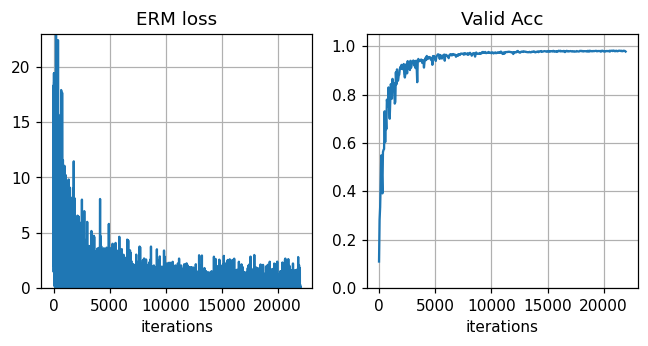

In [224]:
stats = run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, use_momentum, check_gap, shuffle_ratio, decay_rate)
if use_forward_grad:
    print_stats_full(stats)
else:
    print_stats(stats)